In [1]:
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from scipy import stats
from math import sqrt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
%matplotlib inline

In [2]:
marag_df = pd.read_csv('./../../../Databases/marag_lags_data.csv')
marag_df.set_index('Timestamp', inplace=True)
marag_df.sort_index(inplace=True)

# For the time being we will not use the outliers column, so we will drop it
marag_df.drop(['outliers'], axis=1, inplace=True)

marag_df.head()

,TotalEntries,Temperature,Precipitation,Open/Closed,Weekday/Weekend,t-1,t-2,t-3,t-4,t-5,...,t-327,t-328,t-329,t-330,t-331,t-332,t-333,t-334,t-335,t-336
Timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-16 00:00:00,8,9.1,0.0,1,1,17.0,23.0,25.0,53.0,73.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-16 00:30:00,0,8.9,0.0,0,1,8.0,17.0,23.0,25.0,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-16 01:00:00,0,8.8,0.0,0,1,0.0,8.0,17.0,23.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-16 01:30:00,0,8.5,0.0,0,1,0.0,0.0,8.0,17.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-16 02:00:00,0,8.2,0.0,0,1,0.0,0.0,0.0,8.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Let's import the marag data with no lags for future comparative purposes
no_lags_marag = pd.read_csv('./../../../Databases/marag_data.csv')
no_lags_marag.set_index('Timestamp', inplace=True)
no_lags_marag.sort_index(inplace=True)
no_lags_marag.drop(['outliers'], axis=1, inplace=True)
no_lags_marag.head()

,TotalEntries,Temperature,Precipitation,Open/Closed,Weekday/Weekend
Timestamp,,,,,
2017-01-09 00:00:00,0,9.0,0.0,1,1
2017-01-09 00:30:00,0,9.3,0.0,0,1
2017-01-09 01:00:00,0,9.5,0.0,0,1
2017-01-09 01:30:00,0,9.7,0.0,0,1
2017-01-09 02:00:00,0,9.8,0.0,0,1


In [4]:
from ipynb.fs.full.train_dev_test_split import train_dev_test_split

X_train, X_dev, X_test, y_train, y_dev, y_test = train_dev_test_split(marag_df.drop(['TotalEntries'], axis=1), 
                                                                      marag_df['TotalEntries'])
X_train_raw = marag_df[:X_train[-1:].index.astype(str)[0]]


## Linear Regression: all features, classic train_test split

In [5]:
X_train, X_dev, X_test, y_train, y_dev, y_test = train_dev_test_split(marag_df.drop(['TotalEntries'], axis=1), marag_df['TotalEntries'])
lr_X_train = pd.concat([X_train, X_dev])
lr_X_train.sort_index(inplace=True)
lr_y_train = pd.concat([y_train, y_dev])
lr_y_train.sort_index(inplace=True)

In [6]:
lr_model = LinearRegression().fit(lr_X_train, lr_y_train)
lr_y_hat = lr_model.predict(X_test)
lr_y_hat = pd.Series(lr_y_hat, index=y_test.index, name='Predicted_TotalEntries')
lr_residuals = y_test - lr_y_hat

lr_RMSE = np.sqrt(mean_squared_error(y_test, lr_y_hat))
lr_R2 = r2_score(y_test, lr_y_hat)
lr_R2_adj = (1 - (1 - lr_R2)) * ((len(y_test) - 1)/(len(y_test) - X_test.shape[1] - 1))
print('The RMSE is: {}'.format(lr_RMSE))
print('The R2_adjusted is: {}'.format(lr_R2_adj))

The RMSE is: 25.983727664356056
The R2_adjusted is: 0.9986426569991568


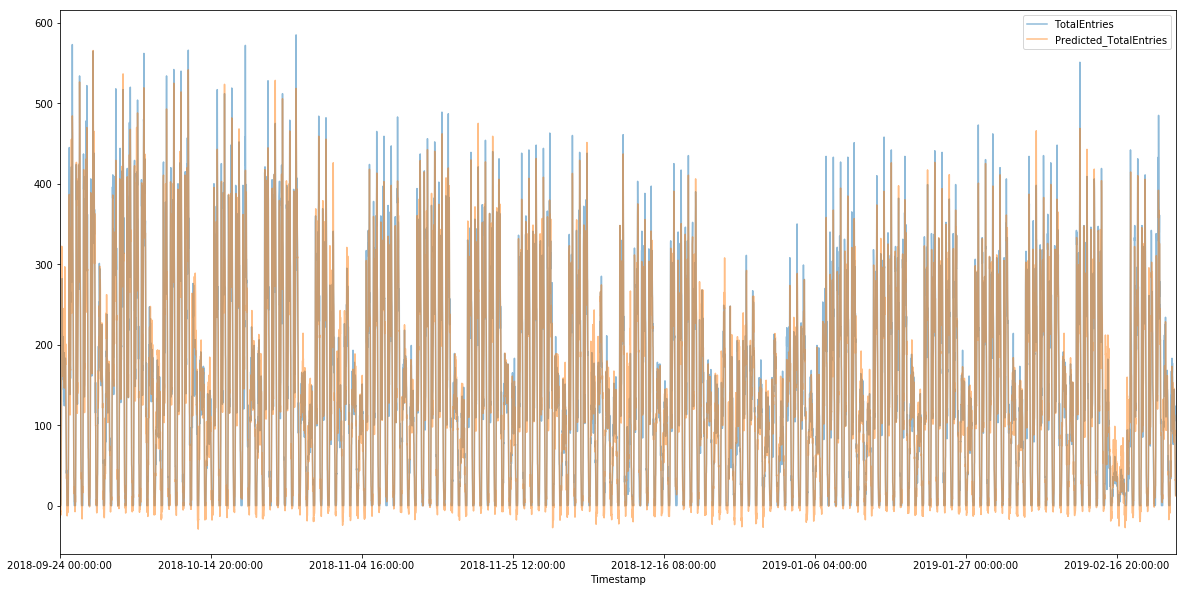

In [7]:
# Let's plot the predicted values against the observed

ax = y_test.plot(figsize=(20,10), alpha=0.5, legend=True)
pd.DataFrame(lr_y_hat).plot(ax = ax, alpha=0.5, legend=True)
plt.show()

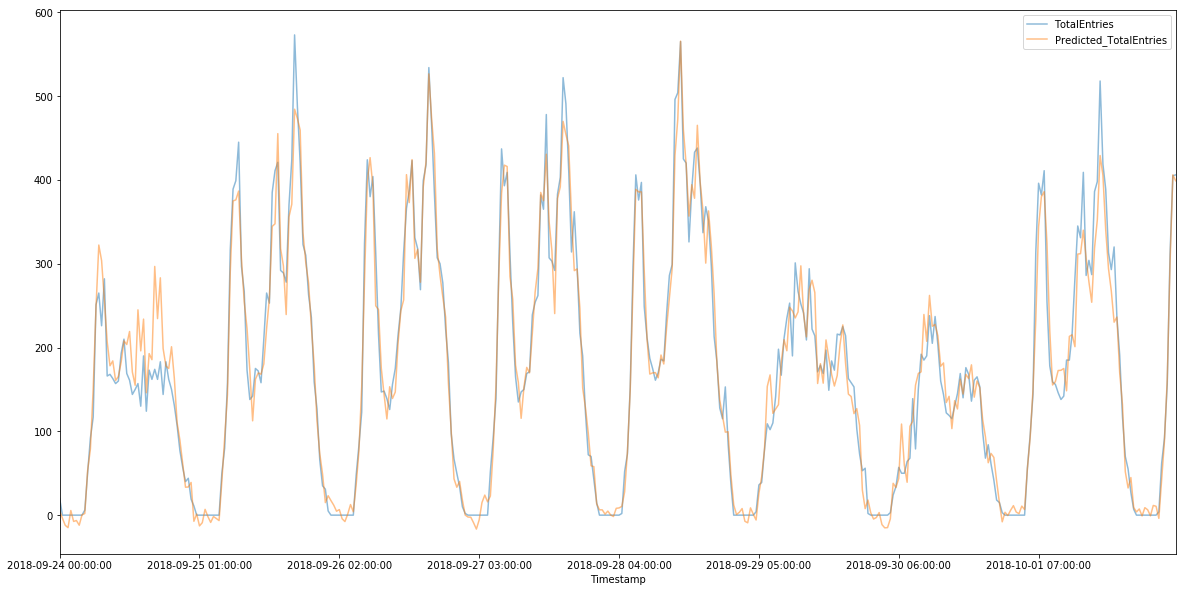

In [8]:
# There are too many observations. Let's plot just a few to get a better idea:

ax = y_test[:400].plot(figsize=(20,10), alpha=0.5, legend=True)
pd.DataFrame(lr_y_hat[:400]).plot(ax = ax, alpha=0.5)
plt.show()

Apparently, with a simple linear regression the predicted values adjust quite well to the observed ones. Let's take a look at the residuals.

#### Residuals analysis

In [9]:
lr_residuals.describe()

count    7392.000000
mean       -0.954718
std        25.967939
min      -151.082226
25%       -14.579923
50%        -0.659242
75%        12.312756
max       169.456383
dtype: float64

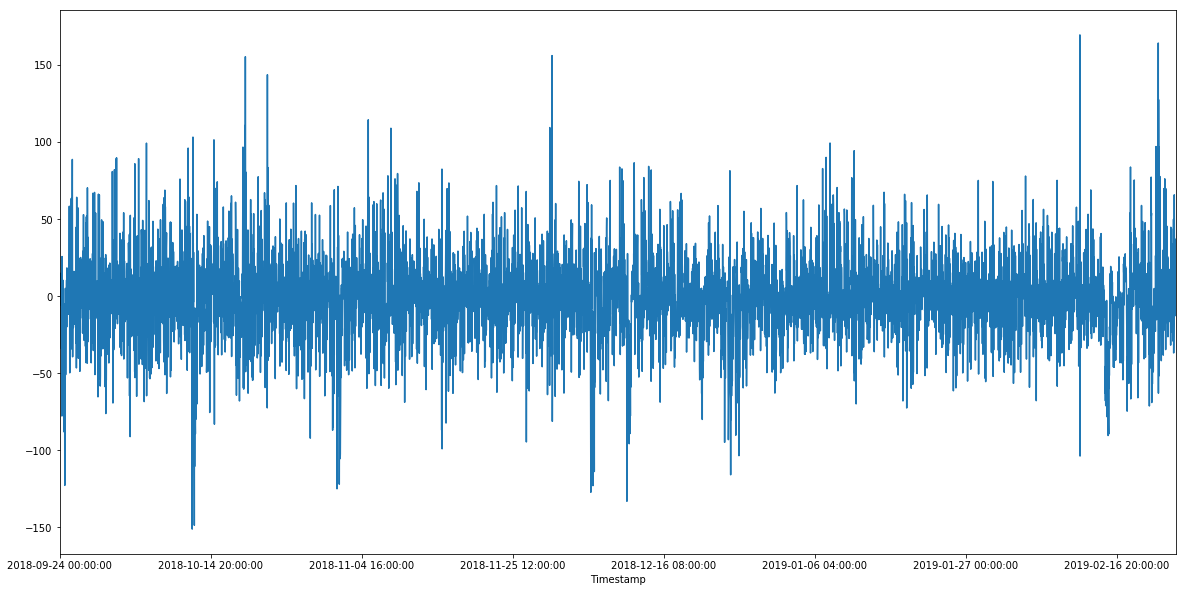

In [10]:
lr_residuals.plot(figsize=(20,10))
plt.show()

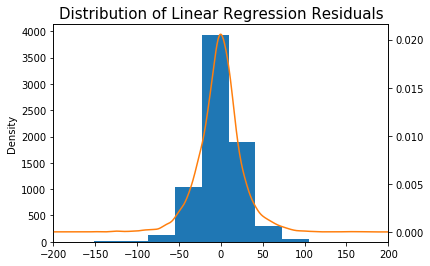

In [11]:
# Histogram and density of residuals

ax = lr_residuals.hist()
lr_residuals.plot(kind='kde', ax=ax, secondary_y=True, xlim=(-200,200))
plt.title('Distribution of Linear Regression Residuals', fontsize=15)
plt.show()

The dsitribution of the residuals is similar to that of a gaussian distribution (most of them near to 0, as seen in the descriptive analysis).

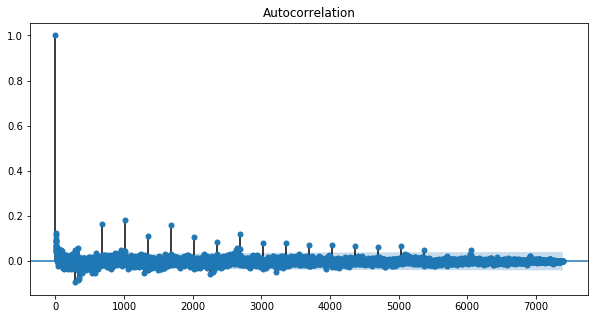

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
with plt.rc_context():
    plt.rc("figure", figsize=(10,5))
    plot_acf(lr_residuals)

We have more than 7000 predicted vaues, so not much information can be extracted from the ACF plot.

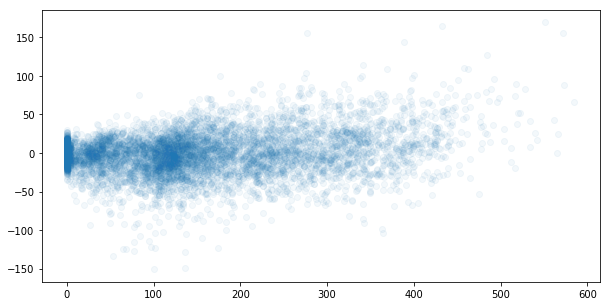

In [13]:
# Plotting residuals against fitted values:

plt.figure(figsize=(10,5))
plt.scatter(y_test, lr_residuals, alpha=0.05)
plt.show()

In [14]:
# Grouping predictions by day:
y_test.index = pd.to_datetime(y_test.index)
lr_y_hat.index = pd.to_datetime(lr_y_hat.index)
y_test_day = y_test.groupby(pd.Grouper(freq='D')).sum()
lr_y_hat_day = lr_y_hat.groupby(pd.Grouper(freq='D')).sum()
lr_y_hat_day.head()

Timestamp
2018-09-24     6700.566585
2018-09-25     9606.624503
2018-09-26     9730.272539
2018-09-27     9980.567132
2018-09-28    10651.364212
Freq: D, Name: Predicted_TotalEntries, dtype: float64

In [15]:
np.sqrt(mean_squared_error(y_test_day, lr_y_hat_day))

375.7729036792198

In [16]:
from ipynb.fs.full.get_future_predictions import get_future_predictions

predict_1_day = get_future_predictions(no_lags_marag, X_train, X_test, lr_model, 1)

100%|██████████| 48/48 [01:00<00:00,  1.21s/it]


In [25]:
y_test[:48].sum()

5719

In [24]:
predict_1_day.sum()

TotalEntries    8195.594157
dtype: float64

Defining a function to estimate future predictions

In [56]:
def get_future_predictions(all_data_df, X_train, X_test, model, N):
    '''Function to forecast predictions N days into the future
    
    Parameters: 
    all_data_df: data frame containing all the information fed to the model and 
    the external data needed for the future predictions.
    
    X_train: data used to feed the model
    
    model: already fed model from which to make predictions.
    
    N: number of days into the future from which to make predictions.
    
    Returns:
    Predictions grouped by day for N days.
    '''
    X_grow = pd.DataFrame(all_data_df['TotalEntries'][:X_train[-1:].index.astype(str)[0]].astype('float64').sort_index())
    y_grow_hat = pd.DataFrame
    y_hat_init = pd.DataFrame(model.predict(X_test[0:1]), index=X_test[0:1].index, columns=['TotalEntries'])
    y_hat = 0
    pred_df = pd.DataFrame
    new_cols = {}
    
    for i in tqdm(range(48*N)):
        if y_grow_hat.empty:
            y_hat = y_hat_init
            
        else:
            pred_df = X_data.drop(['t-' + str(48*7)], axis = 1)
            pred_df.rename(columns=new_cols, inplace=True)
            pred_df.rename(columns={'TotalEntries':'t-1'}, inplace=True)
            
            y_hat = model.predict(pred_df[-1:])
            y_hat = pd.DataFrame(y_hat, index=X_test[i:(i+1)].index, columns=['TotalEntries'])
            
            
               
        if y_grow_hat.empty:
            y_grow_hat = y_hat
            
        else:
            y_grow_hat = pd.concat([y_grow_hat, y_hat])
        
        
        X_grow = pd.concat([X_grow, y_hat])
        X_grow.sort_index(inplace=True)
        
        # Create lags
        X_data = X_grow.copy()
        for l in range(1,48*7+1):
            new_cols['t-' + str(l)] = 't-' + str(l+1)
            X_data['t-' + str(l)] = X_data['TotalEntries'].shift(l)
        
        X_data = X_data.iloc[(48*7):]
        
        # Append the rest of the columns
        X_data = X_data.merge(all_data_df.drop(['TotalEntries'], axis = 1)[X_train[0:1].index[0]:y_hat.index[0]], 
                              how='left', on='Timestamp')
        
        
        model.fit(X_data.drop(['TotalEntries'], axis=1), X_data['TotalEntries'])
    
    
    y_grow_hat.sort_index(inplace=True)
    return y_grow_hat
        

In [31]:
X_test.shape[0]

7392

In [30]:
for i in range(X_test.shape[0]):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360


4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594


7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212
7213
7214
7215
7216
7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240
7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255
7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269
7270
7271
7272
7273
7274
7275
7276
7277
7278
7279
7280
7281
7282
7283
7284
7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319
7320
7321
7322
7323
7324
7325
7326
7327
7328
7329
7330
7331
7332
7333
7334
7335
7336
7337
7338
7339
7340
7341
7342
7343
7344
7345
7346
7347
7348
7349
7350
7351
7352
7353
7354
7355
7356
7357
7358
7359


In [61]:
def OLD_get_future_predictions(all_data_df, X_train, X_test, columns, model, N):
    '''Function to forecast predictions N days into the future
    
    Parameters: 
    all_data_df: data frame containing all the information fed to the model and 
    the external data needed for the future predictions.
    
    X_train: data used to feed the model
    
    model: already fed model from which to make predictions.
    
    N: number of days into the future from which to make predictions.
    
    Returns:
    Predictions grouped by day for N days.
    '''
    X_grow = pd.DataFrame(all_data_df['TotalEntries'][:X_train[-1:].index.astype(str)[0]].astype('float64').sort_index())
    y_grow_hat = pd.DataFrame
    y_hat_init = pd.DataFrame(model.predict(X_test[0:1]), index=X_test[0:1].index, columns=['TotalEntries'])
    y_hat = 0
    pred_df = pd.DataFrame
    new_cols = {}
    
    for i in tqdm(range(48*N)):
        if y_grow_hat.empty:
            y_hat = y_hat_init
            
        else:
            pred_df = X_grow.copy()
            for l in range(1,48*7):
                pred_df['t-'+str(l+1)] = pred_df['TotalEntries'].shift(l)
            pred_df = pred_df.iloc[(48*7-1):]
            #pred_df = X_data.drop(['t-' + str(48*7)], axis = 1)
            #pred_df.rename(columns=new_cols, inplace=True)
            pred_df.rename(columns={'TotalEntries':'t-1'}, inplace=True)
            pred_df = pred_df.merge(all_data_df[X_train[0:1].index[0]:y_hat.index[0]][columns], 
                              how='left', on='Timestamp')
            
            y_hat = model.predict(pred_df[-1:])
            y_hat = pd.DataFrame(y_hat, index=X_test[i:(i+1)].index, columns=['TotalEntries'])
            
            
               
        #y_hat = model.predict(X_test[i:i+1])
        #y_hat = pd.DataFrame(y_hat, index=X_test[i:(i+1)].index, columns=['TotalEntries'])
        if y_grow_hat.empty:
            y_grow_hat = y_hat
        else:
            y_grow_hat = pd.concat([y_grow_hat, y_hat])
        
        
        X_grow = pd.concat([X_grow, y_hat])
        X_grow.sort_index(inplace=True)
        
        # Create lags
        X_data = X_grow.copy()
        for l in range(1,48*7+1):
            new_cols['t-' + str(l)] = 't-' + str(l+1)
            X_data['t-' + str(l)] = X_data['TotalEntries'].shift(l)
        X_data = X_data.iloc[(48*7):]
        #X_data = X_data.merge(all_data_df[X_train[i:i+1].index[0]:y_hat.index[0]][columns], 
        #                      how='left', on='Timestamp')
        
        X_data = X_data.merge(all_data_df[X_train[0:1].index[0]:y_hat.index[0]][columns], 
                              how='left', on='Timestamp')
        
        
        model.fit(X_data.drop(['TotalEntries'], axis=1), X_data['TotalEntries'])
    
    y_grow_hat.sort_index(inplace=True)
    return y_grow_hat, X_data